This code is to fit a spectrum as the sum of two models, and really it's a sum of four models. 

The goal is to map out the space of possible delta-Teff and spot coverage fractions allowed.
I suspect I will have to run this with a prior on either delta-Teff or fS to get something meaningful because of degeneracies

In [90]:
from scipy import interpolate
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
import astropy.units as u
from emcee import EnsembleSampler
from multiprocessing import Pool
from corner import corner
from astropy.io import fits
from multiprocessing import Pool
from scipy import stats
from scipy import optimize
import numpy.random as random
import emcee
import corner
import random
from PyAstronomy import funcFit as fuf
from PyAstronomy import pyasl
from gaussfold import gaussfold as gf
from IPython.display import display, Math
from specutils.fitting import fit_continuum
from specutils.spectra import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum
from astropy.modeling import models
import multiprocessing as mp
Pool = mp.get_context('fork').Pool
from dust_extinction.parameter_averages import F19
# define the model
ext = F19(Rv=3.1)

In [91]:
plt.rcParams['lines.linewidth']   =3
plt.rcParams['axes.linewidth']    = 2
plt.rcParams['xtick.major.width'] =2
plt.rcParams['ytick.major.width'] =2
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.labelweight']='semibold'
plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.weight'] = 'semibold'
plt.rcParams['axes.titleweight']='semibold'
plt.rcParams['axes.titlesize']=9

In [92]:
def getspec(teffs,spectra, inteff): ##  for now other parameters are fixed
    loc = np.where(teffs == inteff)
    #print(inteff,np.shape(spectra),np.shape(teffs))
    above = np.min(np.where(teffs >= inteff))
    below = np.max(np.where(teffs < inteff))
    if np.size(below) < 1 or np.size(above) < 1:
        return(-np.inf)
    
    spec1 = np.squeeze(spectra[:,above])
    spec2 = np.squeeze(spectra[:,below])
    weight = (inteff-teffs[below])/(teffs[above]-teffs[below])
    spec = (1.-weight)*spec2 + weight*spec1
    #else:
    #    spec = np.squeeze(spectra[:,loc])
    return(spec)

## this will take two temperatures (spot and surf) 
##and a coverage fraction (fS) 
## and output the relevant spectrum
def doublespec(teffs,spectra, teff1,teff2,fS):
    spec1 = getspec(teffs,spectra,teff1)
    spec2 = getspec(teffs,spectra,teff2)
    spec = spec1*(1-fS) + spec2*fS
    return(spec)

In [146]:
## parameters we might want to adjust
order = 7

Filename: SDCK_20170316_0102.spec_a0v.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPEC_DIVIDE_A0V    1 PrimaryHDU     274   (2048, 25)   float64   
  1  WAVELENGTH    1 ImageHDU       273   (2048, 25)   float64   
  2  TGT_SPEC      1 ImageHDU       273   (2048, 25)   float32   
  3  A0V_SPEC      1 ImageHDU       273   (2048, 25)   float32   
  4  VEGA_SPEC     1 ImageHDU       273   (2048, 25)   float64   
  5  SPEC_DIVIDE_CONT    1 ImageHDU       273   (2048, 25)   float64   
Filename: SDCH_20170316_0102.spec_a0v.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SPEC_DIVIDE_A0V    1 PrimaryHDU     281   (2048, 28)   float64   
  1  WAVELENGTH    1 ImageHDU       280   (2048, 28)   float64   
  2  TGT_SPEC      1 ImageHDU       280   (2048, 28)   float32   
  3  A0V_SPEC      1 ImageHDU       280   (2048, 28)   float32   
  4  VEGA_SPEC     1 ImageHDU       280   (2048, 28)   float64   
  5  SPEC_DIVIDE_CONT    1 ImageHDU       280   

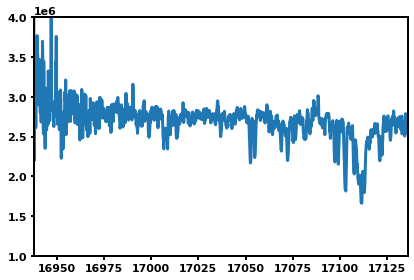

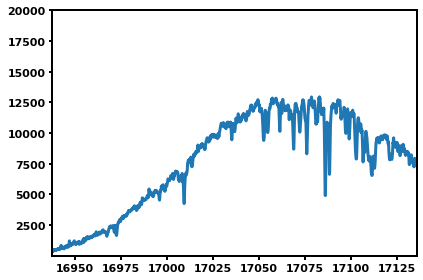

/Users/andrewmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in sqrt


0.020178353


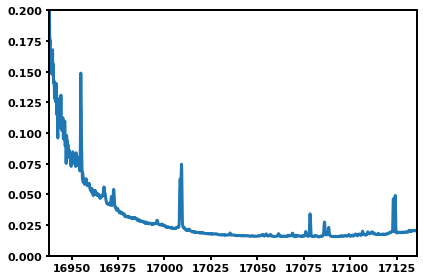

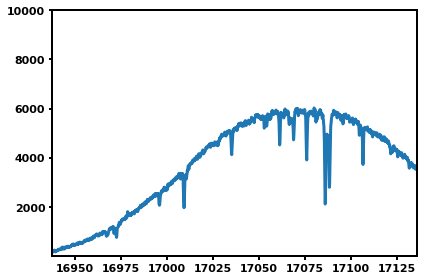

In [109]:
hdul = fits.open('SDCK_20170316_0102.spec_a0v.fits')
hdul.info()
hdr = hdul[1].header
data = hdul[1].data
hdul2 = fits.open('SDCK_20170316_0102.variance.fits')
data2 = hdul2[0].data

hdul = fits.open('SDCH_20170316_0102.spec_a0v.fits')
hdul.info()
hdr = hdul[1].header
data = hdul[1].data
hdul2 = fits.open('SDCH_20170316_0102.variance.fits')
data2 = hdul2[0].data

igspec_diva0 = hdul[0].data
igwave = hdul[1].data*1e4
igspec = hdul[2].data
igspec_a0 = hdul[3].data
igspec_vega = hdul[4].data
igspec_dividecont = hdul[5].data

index = order
wrange = [np.min(igwave[index,:])+20,np.max(igwave[index,:])-20]
plt.plot(igwave[index,:],igspec_diva0[index,:])
plt.xlim(wrange[0],wrange[1])
plt.tight_layout()
plt.ylim(1e6,4e6)
plt.show()
plt.plot(igwave[index,:],igspec[index,:])
plt.xlim(wrange[0],wrange[1])
plt.ylim(1,2e4)
plt.tight_layout()
plt.show()

fracerr = (np.sqrt(data2/igspec**2 + igspec_a0/igspec_a0**2))
print(np.nanmedian(fracerr[index,:]))
plt.plot(igwave[index,:],fracerr[index,:])
plt.xlim(wrange[0],wrange[1])
plt.ylim(0,0.2)
plt.tight_layout()
plt.show()

plt.plot(igwave[index,:],igspec_a0[index,:])
plt.xlim(wrange[0],wrange[1])
plt.ylim(1,1e4)
plt.tight_layout()
plt.show()

#plt.plot(igwave[index,:],igspec_dividecont[index,:])
#plt.xlim(wrange[0],wrange[1])
#plt.ylim(2e6,4e6)
#plt.tight_layout()
#plt.show()

Filename: /Users/andrewmann/Dropbox/Radii/Models_K233_Feb2020.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     36   1R x 7C   [3760A, 13650065E, 65E, 65E, 65E, 65E, 65E]   


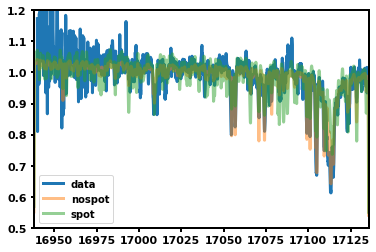

(1704,) (1704,) (1704,)
500.0


In [117]:
igrinswave = np.array(igwave[index,:])
igrinsspec = np.array(igspec_diva0[index,:])
igrinserr = np.array(igrinsspec*fracerr[index,:])
ll = np.where((np.isfinite(igrinserr))&(np.isfinite(igrinswave))&(np.isfinite(igrinsspec)))
igrinsspec = np.squeeze(igrinsspec[ll])
igrinserr = np.squeeze(igrinserr[ll])
igrinswave = np.squeeze(igrinswave[ll])
ll = np.where((igrinswave > wrange[0])&(igrinswave < wrange[1]) )
igrinsspec = igrinsspec[ll]
igrinserr = igrinserr[ll]
igrinswave = igrinswave[ll]
igrinserr/=np.median(igrinsspec[np.where((igrinswave > wrange[0])&(igrinswave < wrange[1]))])
igrinsspec/=np.median(igrinsspec[np.where((igrinswave > wrange[0])&(igrinswave < wrange[1]))])
plt.plot(igrinswave+2,igrinsspec,label='data')

modelpath = '/Users/andrewmann/Dropbox/Radii/Models_K233_Feb2020.fits'
hdul = fits.open(modelpath)
hdul.info()
hdr = hdul[1].header
data = hdul[1].data
lambda0 = 4000
nlambda = 210001
dlambda = 0.1
modelwave = np.linspace(lambda0,lambda0+nlambda*dlambda,num=nlambda)
modelteff = np.squeeze(data['teff'])
modellogg = np.squeeze(data['logg'])
modelafe = np.squeeze(data['a_fe'])
modelmh = np.squeeze(data['metal'])
modelspectra = np.squeeze(data['spectrum'])

#modelspec1 = doublespec(modelteff, modelspectra, 3540,2800,0.2)
#modelspec2= doublespec(modelteff, modelspectra, 3540,2800,0.5)
#modelspec3 = doublespec(modelteff, modelspectra, 3540,2800,0.8)
#for ii in x:
#    print(ii)
#    igrinswave = igwave[ii,:]
#    ll = np.where((modelwave > np.min(igrinswave))&(modelwave < np.max(igrinswave)))
#    plt.plot(modelwave,modelspec3/np.median(modelspec3[ll]),label='80% spots',alpha=0.7)
#    plt.plot(modelwave,modelspec2/np.median(modelspec2[ll]),label='50% spots',alpha=0.7)
#    plt.plot(modelwave,modelspec1/np.median(modelspec1[ll]),label='20% spots',alpha=0.7)
#    plt.xlim(np.min(igrinswave)+10,np.max(igrinswave)-10)
#    plt.ylim(0.3,1.4)
#    plt.legend()
#    plt.show()
    
## resample model spectra
from gaussfold import gaussfold as gf
newlambda = np.array(igrinswave)
newmodel = np.zeros((np.size(newlambda),np.size(modelteff)))
for i in range(0,np.size(modelteff)):
    tmp = np.array(modelspectra[:,i])
    #print(np.shape(modelwave),np.shape(tmp))
    interpfunc = interpolate.interp1d(modelwave, tmp, kind='linear',fill_value="extrapolate")
    modelspec_new = interpfunc(newlambda)
    modelspec_new = gf(newlambda, modelspec_new, np.median(newlambda)/45000)
    newmodel[:,i] = modelspec_new

modelspectra = newmodel
modelwave = newlambda

modelspec = doublespec(modelteff, modelspectra, 3540,3520,0.01)
modelspec/=np.median(modelspec[np.where((modelwave > wrange[0])&(modelwave < wrange[1]))])
plt.plot(modelwave,modelspec,alpha=0.5,label='nospot')
modelspec2 = doublespec(modelteff, modelspectra, 3540,2800,0.7)
modelspec2/=np.median(modelspec2[np.where((modelwave > wrange[0])&(modelwave < wrange[1]))])
plt.plot(modelwave,modelspec2,alpha=0.5,label='spot')
plt.xlim(wrange[0],wrange[1])
plt.ylim(0.5,1.2)
plt.legend()
plt.show()

print(np.shape(modelwave),np.shape(modelspec),np.shape(igrinsspec))

500.0


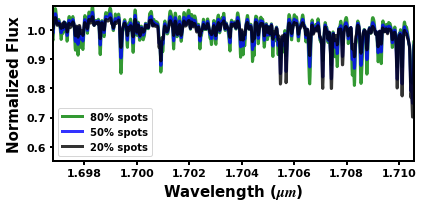

In [118]:
fig, ax = plt.subplots()
fig.set_size_inches(6, 3)

alpha = 0.8
## here let's make some example spectra to show off why this method works
spec3 = doublespec(modelteff,modelspectra,3540,2800,0.8)
plt.plot(modelwave/1e4,spec3/np.median(spec3),label='80% spots',alpha=alpha,color='green')
spec2 = doublespec(modelteff,modelspectra,3540,2800,0.5)
plt.plot(modelwave/1e4,spec2/np.median(spec2),label='50% spots',alpha=alpha,color='blue')
spec1 = doublespec(modelteff,modelspectra,3540,2800,0.2)
plt.plot(modelwave/1e4,spec1/np.median(spec1),label='20% spots',alpha=alpha,color='black')

plt.tight_layout
ax.set_xlim(np.min(modelwave/1e4)+0.003,np.max(modelwave/1e4)-0.003)
#plt.xscale('log')
#plt.yscale('log')
ax.set_ylim(np.min(spec3/np.median(spec3)),np.max(spec3/np.median(spec3)))
plt.legend()
ax.set_ylabel(r'Normalized Flux')
ax.set_xlabel(r'Wavelength ($\mu m$)')
plt.tight_layout()
plt.savefig('Example_spots_highres'+str(order)+'.pdf')


In [119]:
## the likelihood for fitting IGRINS data
## 1) Tsurf
## 2) Tspot 
## 3) small lambda offsets (or RV)
## 4) flux cal errors??
## 5) fS
## 6) broadening
## we can ignore reddening
#define functions for MCMC
def ln_prior(theta):
    Tsurf, Tspot, fS, a, loff, f, broad = theta
    if (a<0.5) or (a>1.5) or (broad < 0.01) or (broad > 10) or (loff < -3) or (loff > 3) or (Tspot < 1000) or (Tspot > 4000) or (Tsurf < 1000) or (Tsurf > 4000) or fS < 0.0 or fS > 1.0 or f < 0 or f > 0.5 or Tspot>(Tsurf-100):
        return -np.inf
    return 0

## warning, wavelengths for model spectra and observational data must match
def ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obserr ):
    Tsurf, Tspot, fS, a, loff, f, broad = theta
    modelspec = doublespec(modelteff,modelspectra,Tsurf,Tspot,fS)
    newwav = wav + loff
    interpfunc = interpolate.interp1d(wav, modelspec, kind='linear',fill_value="extrapolate")
    modelspec_shift = interpfunc(newwav)
    ## vsini broadening
    #print(np.median(wav),np.median(modelspec_shift),broad)
    modelspec_smooth = gf(wav, modelspec_shift, broad)##pyasl.fastRotBroad(newwav, modelspec_shift, 0.0, broad)
    
    modelspec_norm = np.array(modelspec_smooth)/np.mean(modelspec_smooth)
    obsspec_norm = np.array(obsspec)/np.mean(obsspec)
    obsspec_err_norm = np.array(obserr)/np.mean(obsspec)
    
    obsspec_norm*=a
    obsspec_err_norm*=a 
    
    cutoff = 5
    modelspec_norm = modelspec_norm[cutoff:np.size(wav)-cutoff]
    obsspec_norm = obsspec_norm[cutoff:np.size(wav)-cutoff]
    obsspec_err_norm = obsspec_err_norm[cutoff:np.size(wav)-cutoff]
    wav = wav[cutoff:np.size(wav)-cutoff]
    #plt.plot(wav,modelspec_norm)
    #plt.plot(wav,obsspec_norm)
    #plt.show()
    #plt.plot(wav,obsspec_norm/obsspec_err_norm)
    #plt.show()
    
    diff = modelspec_norm - obsspec_norm
    s_squared = np.square(obsspec_err_norm) + np.square(f*obsspec_norm)
    p = (1. / np.sqrt(2. * np.pi * s_squared)) * np.exp(-np.square(diff) / (2. * s_squared)) 
    #tmp = np.sort(p)
    output = np.sum(np.log(p))
    return output

def ln_posterior(theta, modelteff, modelspectra, wav, obsspec, obserr ):
    ln_p = ln_prior(theta)
    if not np.isfinite(ln_p):
        return -np.inf
    ln_like = ln_likelihood(theta, modelteff, modelspectra, wav, obsspec, obserr )
    if not np.isfinite(ln_like):
        return -np.inf
    return ln_p + ln_like

if this is inf, we have a problem:
-5536.646955307917
initializing walkers: (if you see a lot if inf, break this)
-586.8160385131766
-2473.195613595816
-3909.8948814235478
-inf
-14279.387434470384
-inf
-4426.043766028271
112.7785612413229
571.1130744722734
959.6907610203652
-inf
-inf
-inf
1664.8567075883466
-inf
-inf
-inf
-14267.623216669452
-22490.434407199828
1145.0242956478262
-inf
-inf
-1592.9611546454994
1712.2014992563893
-inf
-inf
-7699.623848701305


/Users/andrewmann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log


-inf
-inf
860.2791933142296
948.8906787503413
1861.4669493597348
-inf
-3039.373430507255
-1743.409559992223
-inf
-inf
1638.6215884131825
-inf
-inf
-inf
1152.6605019818849
-inf
1040.37838423855
-1230.0963288114308
1379.2967566990555
-inf
-inf
-inf
-1913.2513768590263
-7540.018505963479
1200.2511055798595
620.2027477661553
-inf
875.6526013037553


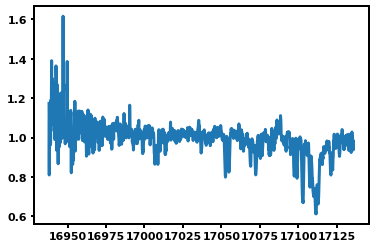

In [120]:
nwalkers, ndim = 30, 7
nthreads = 12
ospec = np.array(list(igrinsspec))
oerr = np.array(list(igrinserr))
mspec = np.array(list(modelspectra))
mteff = np.array(list(modelteff))
mwav = np.array(list(igrinswave))
print('if this is inf, we have a problem:')
initial_guesses = [3500, 2500, 0.2, 1, 0.56, 0.01, 0.5]
print(ln_posterior(initial_guesses,mteff,mspec,mwav,ospec,oerr))
#print(ln_posterior(best,mteff,mspec,mwav,ospec,oerr))

pos0 = []
print('initializing walkers: (if you see a lot if inf, break this)')
while len(pos0) < nwalkers:
    trial = initial_guesses + 0.1 * np.random.randn(ndim)
    lp = ln_posterior(trial,mteff,mspec,mwav,ospec,oerr)
    print(lp)
    if np.isfinite(lp):
        pos0.append(trial)
        
plt.plot(mwav,ospec)
plt.show()

In [121]:
nsteps = 50000
burn = 2000
thin = 1

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior, args=(mteff,mspec,mwav,ospec,oerr), threads=nthreads)
sampler.run_mcmc(pos0, nsteps,progress=True)

print('done')

100%|██████████| 5000/5000 [01:55<00:00, 43.43it/s]


done


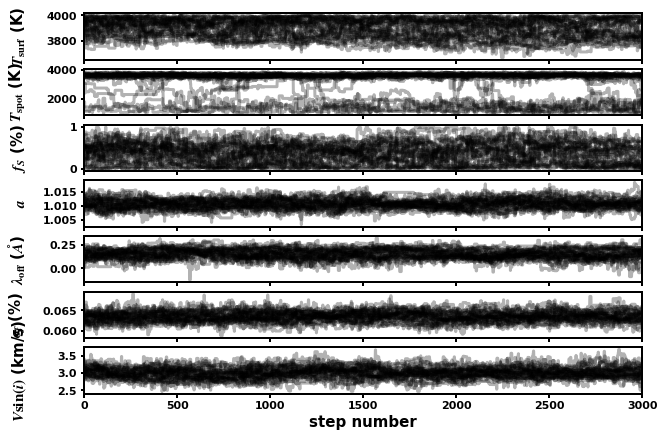

In [152]:
#labels = [r'$T_{\rm{surf}}$',r'$T_{\rm{spot}}$',r'$f_S$',r'$a$',r'$\lambda_{\rm{off}}$','$f$',r'V\sin(i)']
labels = [r'$T_{\rm{surf}}$ (K)',r'$T_{\rm{spot}}$ (K)',r'$f_S$ (%)',r'$a$',r'$\lambda_{\rm{off}}$ ($\AA$)',r'$\sigma_f$ (%)',r'$V\sin(i)$ (km/s)']
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn)
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
#plt.show()
plt.savefig('Walkers_specfit_igrins'+str(order)+'.pdf')

(90000, 7)


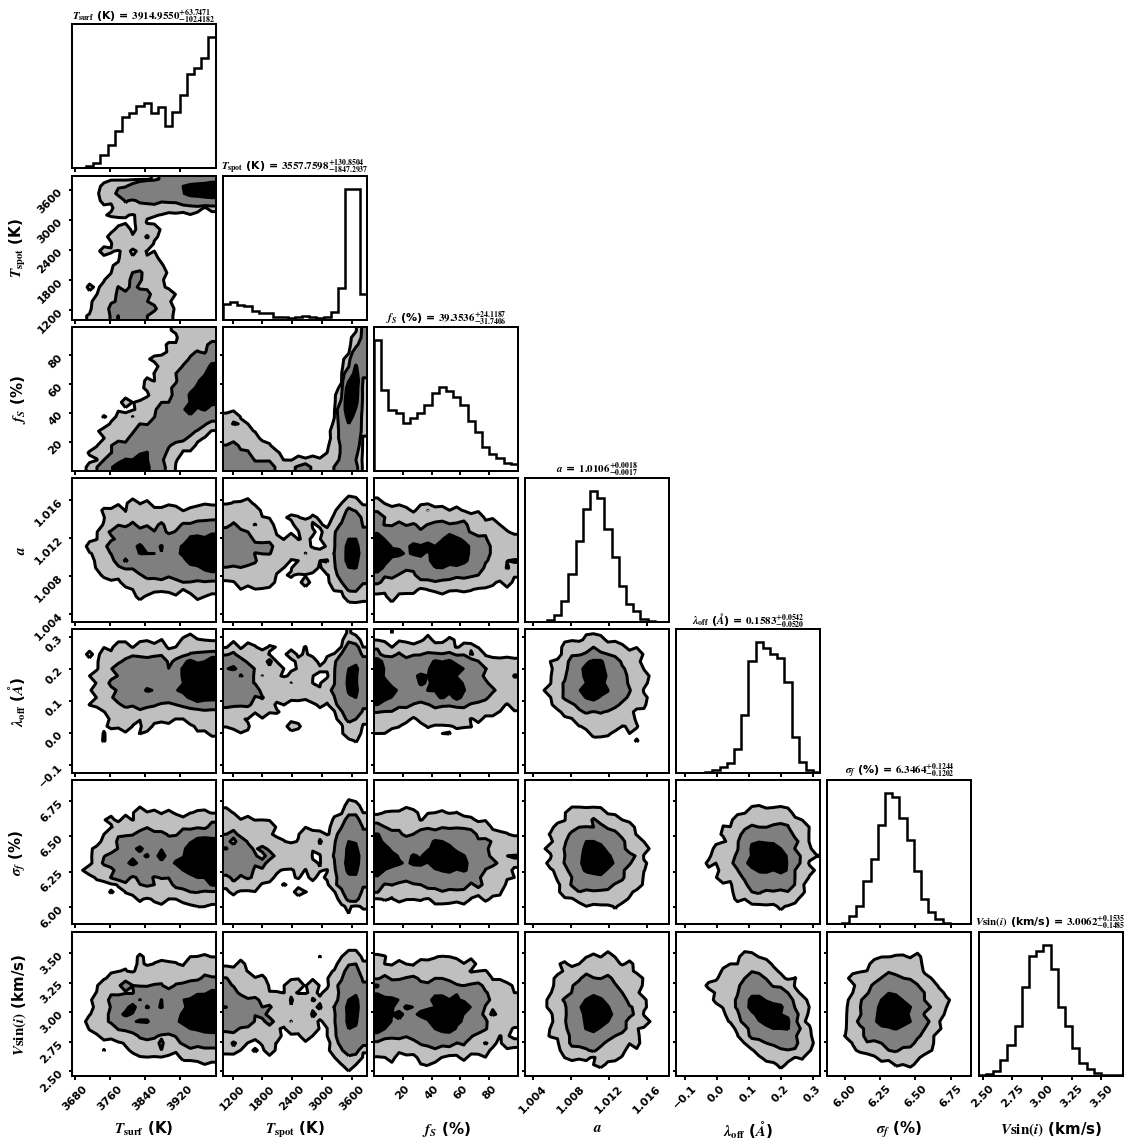

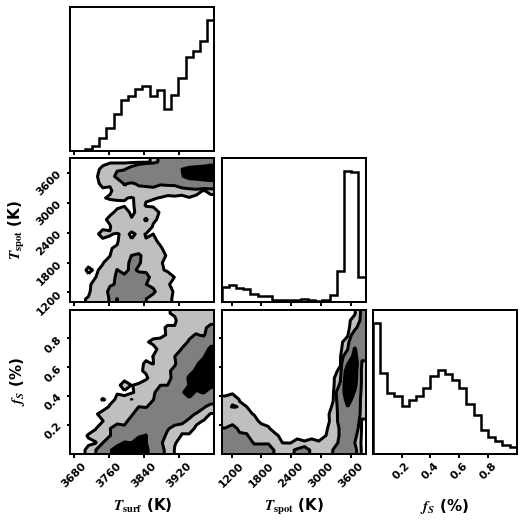

In [153]:
flat = np.array(sampler.get_chain(discard=burn, thin=thin, flat=True))

flat_samples = np.array(flat)
flat_samples[:,2]*=100
flat_samples[:,5]*=100
print(flat_samples.shape)
fig = corner.corner( 
    flat_samples, labels=labels, show_titles=True,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.4f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

#plt.show()
plt.savefig('Corner_spec_igrins'+str(order)+'.pdf')


flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)
prob = sampler.get_log_prob(flat=True,thin=thin,discard=burn)
trimmed_flat = flat_samples[:,0:3]
trimmed_labels = labels[0:3]
fig = corner.corner( 
    trimmed_flat, labels=trimmed_labels, show_titles=False,
    fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 11},title_fmt='.1f',
    hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))]
);

#plt.show()
plt.savefig('Corner_spec_trim_igrins'+str(order)+'.pdf')

In [144]:
## report best-fit parameters
best = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    #if i == 0:
    #    mcmc = np.percentile(np.exp(flat_samples[:, i]), [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    b = flat_samples[np.where(prob == np.max(prob)),i]
    if np.size(b) > 1:
        b = np.squeeze(b)[0]
    best.append(b)

print(best)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

[3997.837896433111, 3583.1625744000366, 0.571340126422667, 1.0097010961828816, 0.20029648271440775, 0.06364043244724973, 3.0113039308350342]


In [125]:
## make a plot showing the best fit and residual
##We should redo that fit above constraining Tsurf to a reasonable range.